In [1]:
import sys
from pathlib import Path

# Add the 'src' directory to the Python path
src_path = Path('../src').resolve()
sys.path.append(str(src_path))


from volume import *
from aspire.volume import Volume
from aspire.utils import Rotation
import numpy as np
import mrcfile 
from aspire.basis import FBBasis3D


In [2]:
with mrcfile.open('../data/emd_34948.map') as mrc:
    data = mrc.data

Vol = Volume(data)
ds_res = 64 
Vol = Vol.downsample(ds_res)
vol = Vol.asnumpy()
vol = vol[0]
n = vol.shape[0]
print(vol.dtype)


float32


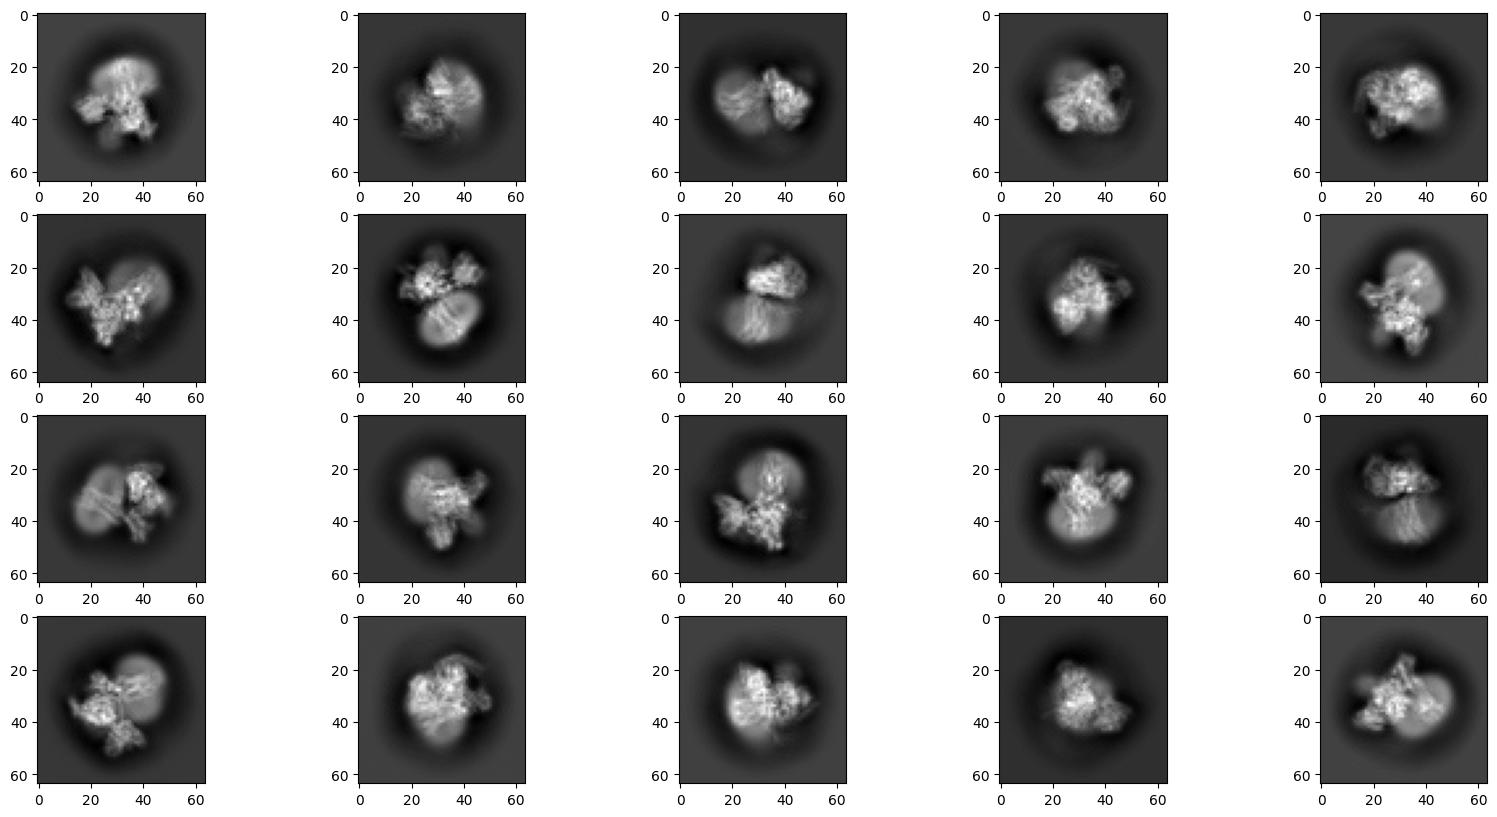

In [3]:
Rots = Rotation(np.eye(3)) 
Rots = Rots.generate_random_rotations(n=20)
Imgs = Vol.project(Rots)
Imgs.show(columns=5,colorbar=False)

In [4]:
ell_max = 10 
vol_coef, k_max, r0, indices = sphFB_transform(vol, ell_max)

In [5]:
vol_expand = coef_t_vol(vol_coef, ell_max, n, k_max, r0, indices)

In [6]:
vol_expand = vol_expand.reshape([n,n,n])
Vol_expand = Volume(vol_expand)

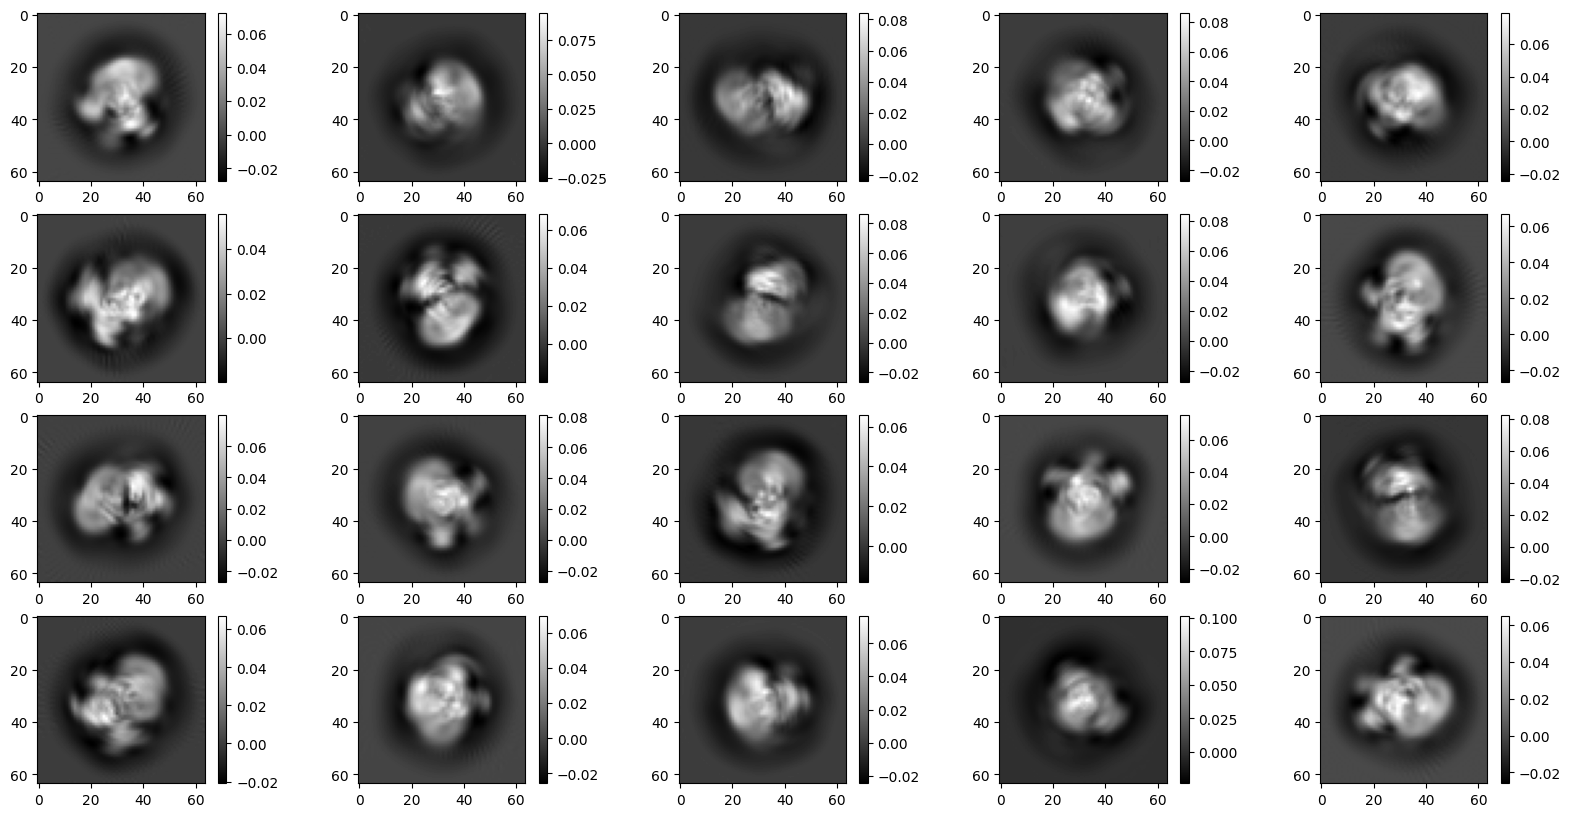

In [7]:
Imgs = Vol_expand.project(Rots)
Imgs.show(columns=5,colorbar=True)

2025-01-25 18:33:09,550 INFO [aspire.basis.fb_3d] Expanding 3D map in a spatial-domain Fourier–Bessel basis using the direct method.


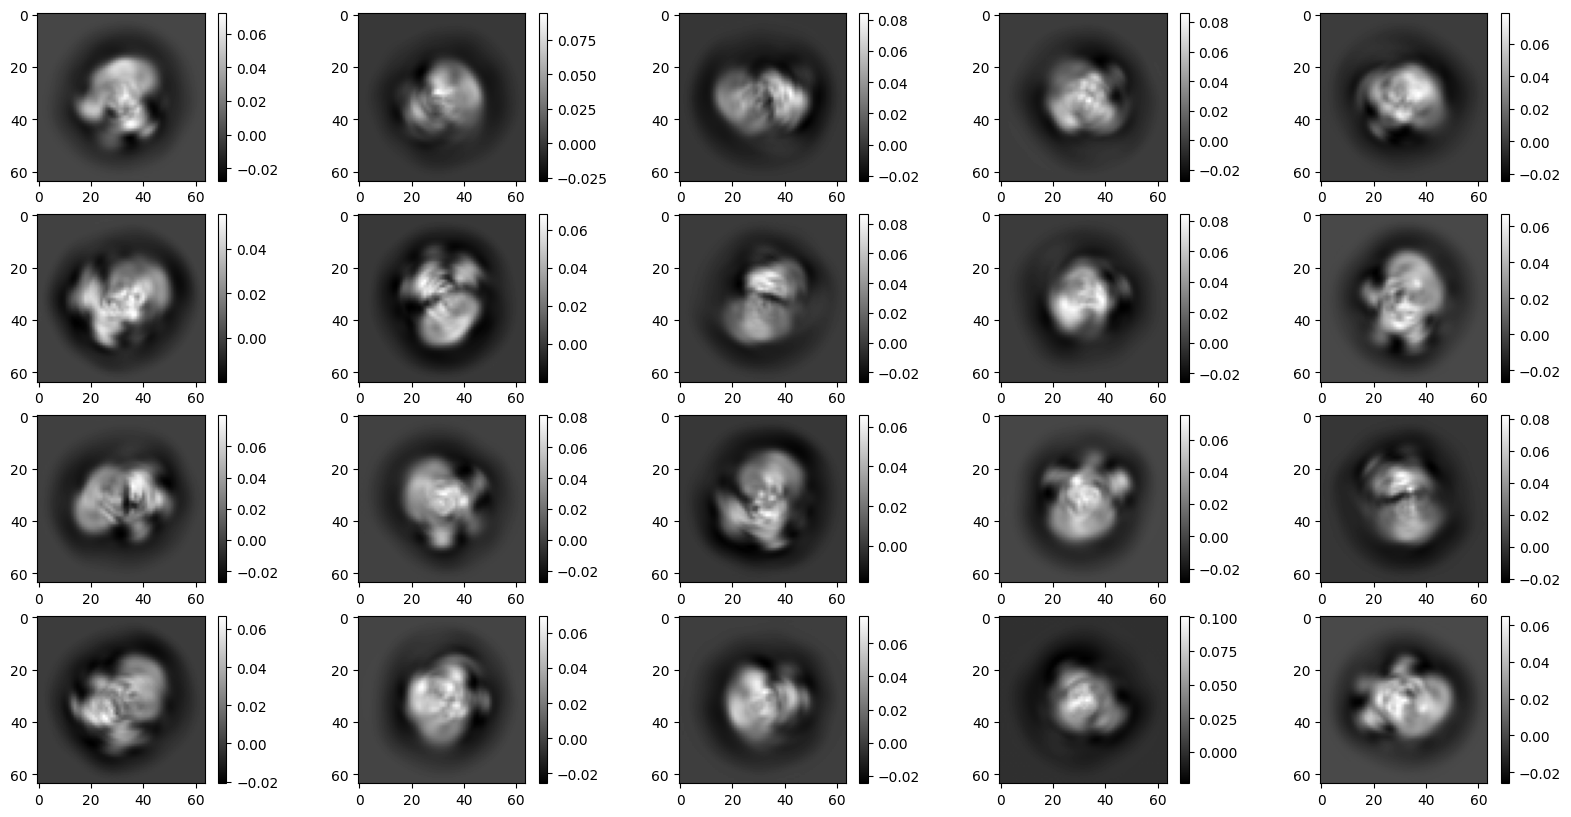

In [8]:
# compare with aspire's real sperical harmonic expansion 

fb_aspire = FBBasis3D(size=n, ell_max=ell_max)
fb_aspire_coef = fb_aspire.evaluate_t(Vol)
Vol_expand_aspire = fb_aspire.evaluate(fb_aspire_coef)
Imgs = Vol_expand_aspire.project(Rots)
Imgs.show(columns=5,colorbar=True)

In [9]:
vol_r_t_c, vol_c_t_r = get_vol_r_t_c_mat(ell_max, k_max, indices)

In [10]:
vol_coef_real = vol_c_t_r @ vol_coef
print(vol_coef_real)

[ 0.35483326-3.87074433e-08j  0.48764109+1.51711275e-08j
  0.86754008+2.65953296e-08j ...  0.00311929-1.71850963e-09j
 -0.00113712+2.30921845e-09j  0.0027123 -2.07756376e-09j]


In [11]:
# # check the orthonormality of spherical harmonic basis 

# r_unique, r_indices = np.unique(xr, return_inverse=True)
# th_unique, th_indices = np.unique(xth, return_inverse=True)
# ph_unique, ph_indices = np.unique(xph, return_inverse=True)

# nb = len(indices['ells'])
# ngrid = len(xr)

# lpall = norm_assoc_legendre_all(ell_max, np.cos(th_unique))
# lpall /= np.sqrt(4*np.pi)

# exp_all = np.zeros((2*ell_max+1,len(ph_unique)), dtype=complex)
# for m in range(-ell_max,ell_max+1):
#     exp_all[m+ell_max,:] = np.exp(1j*m*ph_unique)

# FB3d_basis = np.zeros([ngrid, nb], dtype=complex)

# i = 0 
# for ell in range(0,ell_max+1):
#     for k in range(0,k_max[ell]):
#         z = r0[ell][k]
#         js = spherical_jn(ell, r_unique*z/c)
#         djs = spherical_jn(ell, z, True)
#         js = js*np.sqrt(2/c**3)/abs(djs)

#         for m in range(-ell,ell+1):
#             lpmn = lpall[ell,abs(m),:]
#             if m<0:
#                 lpmn = (-1)**m * lpmn 
#             exps = exp_all[m+ell_max,:]
#             FB3d_basis[:,i] = js[r_indices]*lpmn[th_indices]*exps[ph_indices]*np.sqrt(w)
#             i += 1 
#             print(i,nb)


# # should close to an identity matrix 
# FB3d_basis_conj = np.conj(FB3d_basis)
# M = FB3d_basis_conj.T @ FB3d_basis
# diff = M - np.eye(M.shape[0])
# LA.norm(diff, np.inf)